# EE 379K Lab 5

## Rohan Nagar and Wenyang Fu

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Problem 1: LDA

### Part 1

Generate 20 random points in $d = 3$, from a Gaussian multivariate distribution with mean $[0, 0, 0]$ and covariance matrix $[[1, 0.9, 0.9], [0.9, 1, 0.9], [0.9, 0.9, 1]]$. Call this data with label 1. Also generate 20 random points in $d = 3$ from another Gaussian with mean $[0, 0, 1]$ and covariance $[[1, 0.8, 0.8], [0.8, 1, 0.8], [0.8, 0.8, 1]]$. Call that data with label 2. Create a three dimensional plot of the clouds of data points, labeled with the two labels.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


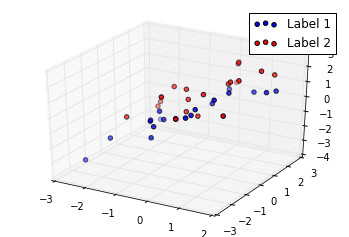

In [2]:
# Covariance matrices
cov1 = [[1, 0.9, 0.9],
        [0.9, 1, 0.9],
        [0.9, 0.9, 1]]
cov2 = [[1, 0.8, 0.8],
        [0.8, 1, 0.8],
        [0.8, 0.8, 1]]

# Generate the samples
label1_samples = np.random.multivariate_normal([0, 0, 0], cov1, 20)
label2_samples = np.random.multivariate_normal([0, 0, 1], cov2, 20)
samples = [label1_samples, label2_samples]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(label1_samples.T[0], label1_samples.T[1], label1_samples.T[2], label='Label 1')
ax.scatter(label2_samples.T[0], label2_samples.T[1], label2_samples.T[2], c='r', label='Label 2')
ax.legend()
fig.show()

### Part 2

Perform a projection of the data on one dimension using Fischer's Linear Discriminant as explained in class (see also http://research.cs.tamu.edu/prism/lectures/pr/pr_l10.pdf). No sklearn LDA functions here, just friendly linear algebra.

#### [Steps to LDA](http://sebastianraschka.com/Articles/2014_python_lda.html)
#### (With help from Sebastian Raschka)
1. Compute the $d$-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors $(e_1,e_2,...,e_d)$ and corresponding eigenvalues $(λ_1,λ_2,...,λ_d)$ for the scatter matrices.
4. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d×k$ dimensional matrix $W$ (where every column represents an eigenvector).
5. Use this $d×k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: $Y=X \times W$ (where $X$ is a $n \times d$-dimensional matrix representing the nn samples, and $Y$ are the transformed $n \times k$-dimensional samples in the new subspace).

In [3]:
# Find the mean feature vector within each class
label1_mean = label1_samples.mean(axis=0)
label2_mean = label2_samples.mean(axis=0)

mean_vectors = [label1_mean, label2_mean]

In [4]:
# Find the within-class scatter matrix

d = label1_mean.shape[0] # number of features
# Shape is d x d, where d is the number of features.
S_W = np.zeros((d,d))  # Between-class scatter matrix

class_sc_matrix = np.zeros((d,d))
# To compute the within-class scatter matrix, sum the outer products of
# each row in the matrix (in-class samples - feature mean vector) with itself
for cl, mv in zip(samples, mean_vectors):
    class_sc_matrix = np.zeros((d,d))
    temp = cl - mv # Subtract mean vector from every row in data matrix
    for row in temp:
        r = row.reshape((d, 1)) # reshape into column vector
        class_sc_matrix += r @ r.T # Outer product
    S_W += class_sc_matrix
    
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[ 35.22045863  31.19242502  27.6092278 ]
 [ 31.19242502  47.01733273  32.41931499]
 [ 27.6092278   32.41931499  32.71319056]]


In [5]:
# Find the between-class scatter matrix

all_samples = np.vstack(samples)
# Mean feature vector for combined samples between all classes
combined_mean_vec = all_samples.mean(axis=0).reshape((-1, 1))
print(combined_mean_vec.shape)

S_B = np.zeros((d,d))

for cl, mean_vec in zip(samples, mean_vectors):
    n = cl.shape[0]  #Number of samples within each class
    mean_vec = mean_vec.reshape((-1,1)) # make column vector
    temp = mean_vec - combined_mean_vec
    S_B += n * temp @ temp.T

print('between-class Scatter Matrix:\n', S_B)

(3, 1)
between-class Scatter Matrix:
 [[  2.63490635   0.78480659   7.73041472]
 [  0.78480659   0.23375457   2.30250325]
 [  7.73041472   2.30250325  22.67986176]]


### Solving the generalized eigenvalue problem for the matrix $S^{−1}_WS_B$

In [6]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W) @ S_B)

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:, i].reshape(-1, 1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2090466 ]
 [-0.44407122]
 [ 0.87126361]]
Eigenvalue 1: 2.05e+00

Eigenvector 2: 
[[-0.01106547]
 [ 0.99519723]
 [-0.09726268]]
Eigenvalue 2: 1.16e-16

Eigenvector 3: 
[[-0.21941619]
 [ 0.97533044]
 [-0.02422957]]
Eigenvalue 3: 2.56e-17


In [7]:
# Sort eigenvectors by their corresponding eigenvalues in descending order:
# aka highest to lowest
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

2.05450405032
1.15589468394e-16
2.56013946377e-17


In [8]:
# "Explained variance"

print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%
eigenvalue 3: 0.00%


In [9]:
# Choose eigenvector with the highest eigenvalue:

W = eig_pairs[0][1]
print('Matrix W:\n', W.real)

Matrix W:
 [-0.2090466  -0.44407122  0.87126361]


#### Project data matrix onto new subspace:
$Y = X \times W$

In [10]:
label1_lda = label1_samples @ W
label2_lda = label2_samples @ W
label1_lda

array([-0.39253039, -0.01697014, -0.05811467, -0.15845428,  0.2870207 ,
       -0.09636727,  0.19650971,  0.18817684, -0.23116674,  0.21813536,
        0.18814665, -0.79352544, -0.58469598, -0.89977685,  0.29431655,
       -0.2596799 , -0.34100403, -0.14435295, -0.27355947,  0.06410922])

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


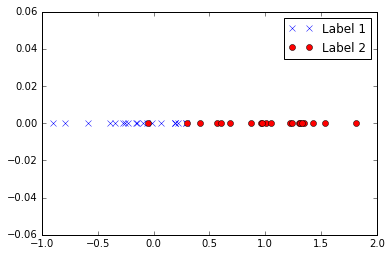

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(label1_lda, np.zeros(label1_lda.shape[0]), label='Label 1', marker='x', linestyle='')
ax.plot(label2_lda, np.zeros(label2_lda.shape[0]), c='r', label='Label 2', marker='o', linestyle='')
ax.legend()
fig.show()

### Part 3

Use $\tt{sklearn}$ to perform Linear Discriminant Analysis. Compare the results.

### The the variants of LDA produced the same results, and both achieved the goal of separating the two classes very well.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


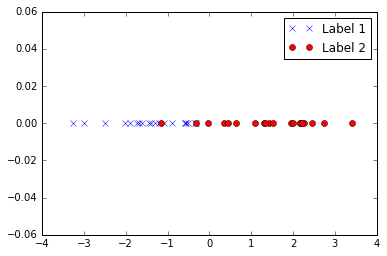

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
n_class1 = label1_samples.shape[0]
n_class2 = label2_samples.shape[0]

sklearn_lda = LDA(n_components=1)
y = np.hstack((np.zeros(n_class1), np.ones(n_class2)))
lda_data = sklearn_lda.fit_transform(all_samples, y)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lda_data[:n_class1], np.zeros(label1_lda.shape[0]), label='Label 1', marker='x', linestyle='')
ax.plot(lda_data[n_class1:], np.zeros(label2_lda.shape[0]),  c='r', label='Label 2', marker='o', linestyle='')
ax.legend()
fig.show()

# Problem 2: More Kaggle

### Part 1

Goal: Get the best score you can in the Housing prices competition. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

### Part 2

Train a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?

### Part 3

Plot the $l_0$ norm (number of nonzeros) of the coefficients that lasso produces as you vary alpha.

### Part 4

Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (this is called ensembling and stacking). Be careful not to overfit. What score can you get?

### Part 5

Install XGBoost and train a gradient boosting regression. What score can you get just from a single XGB? (you will need to optimize over its parameters).

### Part 6

Do your best to win. Try feature engineering and stacking many models. You are allowed to use any public tool in Python. No nonpython tools allowed.

### Part 7

Read (and post) in the Kaggle forums. Include in your report if you find something in the forums that you like, or if you made a post or code, especially if other Kagglers used it afterwards.

### Part 8

Be sure you do not violate the rules of Kaggle! No sharing of code or data outside of the Kaggle forums. Every student should have their own individual Kaggle account and teams can be formed in the Kaggle submissions with your lab partner.

### Part 9

You will be graded based on your public score (include that in your report) and also on the creativity of your solution. In your report, explain what worked and what did not work. Many creative things will not work, but you will get partial credit for developing them. We will invite teams with interesting solutions to present them in class.